# Clustering to Map Lockdown Impact

## Data Collection

### Daily case report collection

In [1]:
import os,glob,sys
import pandas as pd
import numpy as np

In [2]:
# Daily report archive from MoHFW Inida
data_storage = '/Volumes/Lab/covid19-AnalyticsHbub/India/data/'
files = os.listdir(data_storage+'mhw_ind_covid_daily_reports/')
# Read all file and concat
covid19in_df = pd.concat((pd.read_csv(data_storage+'mhw_ind_covid_daily_reports/'+file) for file in sorted(files)[2:]),ignore_index=False) 
covid19in_df.head()

,State/UT,Confirmed,Recovered,Deaths,report_date
0,Andhra Pradesh,19,1,0,2020-03-30
1,Andaman and Nicobar Islands,9,0,0,2020-03-30
2,Bihar,11,0,1,2020-03-30
3,Chandigarh,8,0,0,2020-03-30
4,Chhattisgarh,7,0,0,2020-03-30


In [3]:
covid19in_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941 entries, 0 to 27
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   State/UT     941 non-null    object
 1   Confirmed    941 non-null    int64 
 2   Recovered    941 non-null    int64 
 3   Deaths       941 non-null    int64 
 4   report_date  941 non-null    object
dtypes: int64(3), object(2)
memory usage: 44.1+ KB


## Collect External Source of Data

- Demography and hospital dataset from Kaggle
- Test data by state from Kaggle 
- Lockdown and School closing from News Manually before 25th March announcement 
- Tourist visit by State 
- Industry and Business detail with capital city 

### Tourism data by state

In [4]:
# Tourism data by state
ind_st_tr = pd.read_csv(data_storage+'state_tourism1.csv',index_col=0)
data = covid19in_df.merge(ind_st_tr, how='left', left_on='State/UT', right_on='states')

In [5]:
data = data[data['State/UT'] != 'India']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 939
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   State/UT     923 non-null    object 
 1   Confirmed    923 non-null    int64  
 2   Recovered    923 non-null    int64  
 3   Deaths       923 non-null    int64  
 4   report_date  923 non-null    object 
 5   states       923 non-null    object 
 6   DTV18        923 non-null    float64
 7   FTV18        923 non-null    float64
dtypes: float64(2), int64(3), object(3)
memory usage: 64.9+ KB


In [6]:
data.head()

,State/UT,Confirmed,Recovered,Deaths,report_date,states,DTV18,FTV18
0,Andhra Pradesh,19,1,0,2020-03-30,Andhra Pradesh,194767874.0,281083.0
1,Andaman and Nicobar Islands,9,0,0,2020-03-30,Andaman and Nicobar Islands,498279.0,15242.0
2,Bihar,11,0,1,2020-03-30,Bihar,33621613.0,1087971.0
3,Chandigarh,8,0,0,2020-03-30,Chandigarh,1538796.0,39681.0
4,Chhattisgarh,7,0,0,2020-03-30,Chhattisgarh,19329501.0,14399.0


### Lockdown entry date wise taking School Closed date, Janta Carfew and final Lockdown Announcement

- first carfew: State Announcement for school closed till 31st March before 18th Marcb because after 18 march every state of india closed education system and stated Janta Carfew
- final carfew: Nationwide Lockdown after PM announcement from 25th March

In [7]:
school_ldf = pd.read_csv(data_storage+'india_state_school_close.csv', date_parser='date')
school_ldf['date'] = pd.to_datetime(school_ldf['date'], format='%d/%m/%y')
school_ldf['date'] = school_ldf['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
data = covid19in_df.merge(school_ldf, how = 'left', left_on=covid19in_df.report_date+'-'+covid19in_df['State/UT'], 
                  right_on=school_ldf['date']+'-'+school_ldf['State/UT'])
data.drop(columns=['key_0', 'State/UT_y', 'date'], inplace=True)
data.rename(columns={'State/UT_x': 'State/UT'}, inplace=True)
# Define Lockdown category
data['lockdown_type'] = np.where(data['report_date'] < '2020-03-06', 'Open', data['lockdown_type'])
data['lockdown_type'] = np.where(data['report_date'] > '2020-03-23', 'National', data['lockdown_type'])
data['lockdown_type'].fillna('Local', inplace=True)
data['lockdown_type'] = data.lockdown_type.str.strip()

In [8]:
data['lockdown_type'].fillna('Local', inplace=True)
#data['lockdown_type'].fillna('Janta Carfew', inplace=True)
#data['lockdown_type'] = data.lockdown_type.str.strip()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941 entries, 0 to 940
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   State/UT       941 non-null    object
 1   Confirmed      941 non-null    int64 
 2   Recovered      941 non-null    int64 
 3   Deaths         941 non-null    int64 
 4   report_date    941 non-null    object
 5   lockdown_type  941 non-null    object
dtypes: int64(3), object(3)
memory usage: 51.5+ KB


In [9]:
data[data['State/UT'] == 'Delhi'].sort_values(by='report_date')

,State/UT,Confirmed,Recovered,Deaths,report_date,lockdown_type
499,Delhi,1,0,0,2020-03-02,Open
503,Delhi,1,0,0,2020-03-03,Open
507,Delhi,1,0,0,2020-03-04,Open
510,Delhi,2,0,0,2020-03-05,Open
516,Delhi,3,0,0,2020-03-06,Local
527,Delhi,3,0,0,2020-03-07,Local
536,Delhi,3,0,0,2020-03-08,Local
549,Delhi,4,0,0,2020-03-09,Local
552,Delhi,4,0,0,2020-03-10,Local
563,Delhi,5,0,0,2020-03-11,Local


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941 entries, 0 to 940
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   State/UT       941 non-null    object
 1   Confirmed      941 non-null    int64 
 2   Recovered      941 non-null    int64 
 3   Deaths         941 non-null    int64 
 4   report_date    941 non-null    object
 5   lockdown_type  941 non-null    object
dtypes: int64(3), object(3)
memory usage: 51.5+ KB


### Census Data

In [11]:
data_dir = '/Users/kaushalk/Downloads/covid19-in-india/'
dfile = os.listdir(data_dir)

In [12]:
[x for x in [dfile[2], dfile[6]]]

['HospitalBedsIndia.csv', 'population_india_census2011.csv']

In [13]:
[x for x in sorted(dfile)]

['AgeGroupDetails.csv',
 'HospitalBedsIndia.csv',
 'ICMRTestingDetails.csv',
 'ICMRTestingLabs.csv',
 'IndividualDetails.csv',
 'StatewiseTestingDetails.csv',
 'covid_19_india.csv',
 'population_india_census2011.csv']

In [14]:
hpbed_df = pd.read_csv(data_dir+dfile[2])
popul_df = pd.read_csv(data_dir+dfile[6])

In [15]:
popul_df.head()

,Sno,State / Union Territory,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
1,2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
2,3,Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
3,4,West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
4,5,Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


In [16]:
import re

In [17]:
popul_df['area_new'] = [re.findall(r'\d+', x)[:2] for x in popul_df.Area]
popul_df['area_new'] = popul_df['area_new'].str[0]+popul_df['area_new'].str[1]
popul_df['area_new'] = pd.to_numeric(popul_df['area_new'])
popul_df = popul_df[['State / Union Territory', 'Population', 'Rural population',
       'Urban population', 'Gender Ratio', 'area_new']]
popul_df.columns = ['states', 'pop_mi', 'ru_pop', 'urb_pop','gender_ratio', 'area']
popul_df['density'] = round(popul_df.pop_mi.div(popul_df.area),1)
popul_df['states'] = [x.strip() for x in popul_df['states']]
#popul_df['states'].replace('Telengana', 'Telangana', inplace=True)

In [18]:
popul_df.head()

,states,pop_mi,ru_pop,urb_pop,gender_ratio,area,density
0,Uttar Pradesh,199812341,155317278,44495063,912,240928,829.3
1,Maharashtra,112374333,61556074,50818259,929,307713,365.2
2,Bihar,104099452,92341436,11758016,918,94163,1105.5
3,West Bengal,91276115,62183113,29093002,953,88752,1028.4
4,Madhya Pradesh,72626809,52557404,20069405,931,308245,235.6


In [19]:
popul_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   states        36 non-null     object 
 1   pop_mi        36 non-null     int64  
 2   ru_pop        36 non-null     int64  
 3   urb_pop       36 non-null     int64  
 4   gender_ratio  36 non-null     int64  
 5   area          36 non-null     int64  
 6   density       36 non-null     float64
dtypes: float64(1), int64(5), object(1)
memory usage: 2.1+ KB


In [20]:
hpbed_df.head()

,Sno,State/UT,NumPrimaryHealthCenters_HMIS,NumCommunityHealthCenters_HMIS,NumSubDistrictHospitals_HMIS,NumDistrictHospitals_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,NumRuralHospitals_NHP18,NumRuralBeds_NHP18,NumUrbanHospitals_NHP18,NumUrbanBeds_NHP18,Unnamed: 12,Unnamed: 13
0,1.0,Andaman & Nicobar Islands,27,4,NaN,3,34,1246,27.0,575.0,3.0,500.0,NaN,NaN
1,2.0,Andhra Pradesh,1417,198,31,20,1666,60799,193.0,6480.0,65.0,16658.0,NaN,NaN
2,3.0,Arunachal Pradesh,122,62,NaN,15,199,2320,208.0,2136.0,10.0,268.0,NaN,NaN
3,4.0,Assam,1007,166,14,33,1220,19115,1176.0,10944.0,50.0,6198.0,NaN,NaN
4,5.0,Bihar,2007,63,33,43,2146,17796,930.0,6083.0,103.0,5936.0,NaN,NaN


In [27]:
hpbed_df = hpbed_df.iloc[:-2, 1:-2]

In [28]:
#hpbed_df = hpbed_df.iloc[:-2,1:-2]
hpbed_df['State/UT'] = [x.replace('&','and').strip() for x in hpbed_df['State/UT'].str.strip()]
hpbed_df['State/UT'] = hpbed_df['State/UT'].replace('Telangana','Telengana')
hpbed_df.head()

,State/UT,NumPrimaryHealthCenters_HMIS,NumCommunityHealthCenters_HMIS,NumSubDistrictHospitals_HMIS,NumDistrictHospitals_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,NumRuralHospitals_NHP18,NumRuralBeds_NHP18,NumUrbanHospitals_NHP18,NumUrbanBeds_NHP18
0,Andaman and Nicobar Islands,27,4,NaN,3,34,1246,27.0,575.0,3.0,500.0
1,Andhra Pradesh,1417,198,31,20,1666,60799,193.0,6480.0,65.0,16658.0
2,Arunachal Pradesh,122,62,NaN,15,199,2320,208.0,2136.0,10.0,268.0
3,Assam,1007,166,14,33,1220,19115,1176.0,10944.0,50.0,6198.0
4,Bihar,2007,63,33,43,2146,17796,930.0,6083.0,103.0,5936.0


In [29]:
popul_df1 = popul_df.merge(hpbed_df, how='left', left_on='states', right_on = 'State/UT')

In [30]:
hpbed_df['State/UT'].unique()

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
       'Chhattisgarh', 'Dadra and Nagar Haveli', 'Daman and Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telengana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'],
      dtype=object)

In [31]:
popul_df1[popul_df1['states'] == 'Telengana']

,states,pop_mi,ru_pop,urb_pop,gender_ratio,area,density,State/UT,NumPrimaryHealthCenters_HMIS,NumCommunityHealthCenters_HMIS,NumSubDistrictHospitals_HMIS,NumDistrictHospitals_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,NumRuralHospitals_NHP18,NumRuralBeds_NHP18,NumUrbanHospitals_NHP18,NumUrbanBeds_NHP18
11,Telengana,35003674,21395009,13608665,988,112077,312.3,Telengana,788,82,47,15,932,17358,802.0,7668.0,61.0,13315.0


### Merge Data

In [32]:
ind_st_tr.shape, popul_df1.shape, hpbed_df.shape

((37, 3), (36, 18), (36, 11))

In [33]:
ind_st_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 105
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   states  37 non-null     object 
 1   DTV18   37 non-null     float64
 2   FTV18   37 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.2+ KB


In [34]:
popul_df.states.unique()

array(['Uttar Pradesh', 'Maharashtra', 'Bihar', 'West Bengal',
       'Madhya Pradesh', 'Tamil Nadu', 'Rajasthan', 'Karnataka',
       'Gujarat', 'Andhra Pradesh', 'Odisha', 'Telengana', 'Kerala',
       'Jharkhand', 'Assam', 'Punjab', 'Chhattisgarh', 'Haryana',
       'Uttarakhand', 'Himachal Pradesh', 'Tripura', 'Meghalaya',
       'Manipur', 'Nagaland', 'Goa', 'Arunachal Pradesh', 'Mizoram',
       'Sikkim', 'Delhi', 'Jammu and Kashmir', 'Puducherry', 'Chandigarh',
       'Dadra and Nagar Haveli and Daman and Diu',
       'Andaman and Nicobar Islands', 'Ladakh', 'Lakshadweep'],
      dtype=object)

In [35]:
popul_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   states        36 non-null     object 
 1   pop_mi        36 non-null     int64  
 2   ru_pop        36 non-null     int64  
 3   urb_pop       36 non-null     int64  
 4   gender_ratio  36 non-null     int64  
 5   area          36 non-null     int64  
 6   density       36 non-null     float64
dtypes: float64(1), int64(5), object(1)
memory usage: 2.1+ KB


In [36]:
hpbed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   State/UT                          36 non-null     object 
 1   NumPrimaryHealthCenters_HMIS      36 non-null     object 
 2   NumCommunityHealthCenters_HMIS    36 non-null     object 
 3   NumSubDistrictHospitals_HMIS      29 non-null     object 
 4   NumDistrictHospitals_HMIS         36 non-null     object 
 5   TotalPublicHealthFacilities_HMIS  36 non-null     object 
 6   NumPublicBeds_HMIS                36 non-null     object 
 7   NumRuralHospitals_NHP18           36 non-null     float64
 8   NumRuralBeds_NHP18                36 non-null     float64
 9   NumUrbanHospitals_NHP18           36 non-null     float64
 10  NumUrbanBeds_NHP18                36 non-null     float64
dtypes: float64(4), object(7)
memory usage: 3.2+ KB


In [37]:
static_ind_df = ind_st_tr.merge(popul_df, how='left', on='states').merge(hpbed_df, how='left', left_on='states', right_on='State/UT')

In [38]:
static_ind_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 36
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   states                            37 non-null     object 
 1   DTV18                             37 non-null     float64
 2   FTV18                             37 non-null     float64
 3   pop_mi                            35 non-null     float64
 4   ru_pop                            35 non-null     float64
 5   urb_pop                           35 non-null     float64
 6   gender_ratio                      35 non-null     float64
 7   area                              35 non-null     float64
 8   density                           35 non-null     float64
 9   State/UT                          34 non-null     object 
 10  NumPrimaryHealthCenters_HMIS      34 non-null     object 
 11  NumCommunityHealthCenters_HMIS    34 non-null     object 
 12  NumSubDist

### Statewise Test Data

In [39]:
statewise_test_df = pd.read_csv(data_dir+dfile[4])

In [40]:
statewise_test_df['Date'] = [dt.strftime("%Y-%m-%d") for dt in pd.to_datetime(statewise_test_df.Date)]

In [41]:
statewise_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          201 non-null    object 
 1   State         201 non-null    object 
 2   TotalSamples  201 non-null    int64  
 3   Negative      198 non-null    float64
 4   Positive      201 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 8.0+ KB


In [42]:
statewise_test_df[statewise_test_df.Negative.isna()]

,Date,State,TotalSamples,Negative,Positive
97,2020-03-31,Tamil Nadu,2354,NaN,124
105,2020-04-01,Tamil Nadu,2726,NaN,234
116,2020-04-03,Jammu and Kashmir,1218,NaN,75


### Final Dataset

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941 entries, 0 to 940
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   State/UT       941 non-null    object
 1   Confirmed      941 non-null    int64 
 2   Recovered      941 non-null    int64 
 3   Deaths         941 non-null    int64 
 4   report_date    941 non-null    object
 5   lockdown_type  941 non-null    object
dtypes: int64(3), object(3)
memory usage: 51.5+ KB


In [44]:
final_df = data.merge(static_ind_df, how='left', left_on='State/UT', right_on='states')

In [45]:
final_df.columns

Index(['State/UT_x', 'Confirmed', 'Recovered', 'Deaths', 'report_date',
       'lockdown_type', 'states', 'DTV18', 'FTV18', 'pop_mi', 'ru_pop',
       'urb_pop', 'gender_ratio', 'area', 'density', 'State/UT_y',
       'NumPrimaryHealthCenters_HMIS', 'NumCommunityHealthCenters_HMIS',
       'NumSubDistrictHospitals_HMIS', 'NumDistrictHospitals_HMIS',
       'TotalPublicHealthFacilities_HMIS', 'NumPublicBeds_HMIS',
       'NumRuralHospitals_NHP18', 'NumRuralBeds_NHP18',
       'NumUrbanHospitals_NHP18', 'NumUrbanBeds_NHP18'],
      dtype='object')

In [46]:
final_df = final_df[['State/UT_x', 'Confirmed', 'Recovered', 'Deaths', 'report_date',
       'lockdown_type', 'DTV18', 'FTV18', 'pop_mi', 'ru_pop',
       'urb_pop', 'gender_ratio', 'area', 'density', 'NumPrimaryHealthCenters_HMIS', 'TotalPublicHealthFacilities_HMIS', 'NumPublicBeds_HMIS']]
final_df.rename(columns={'State/UT_x': 'State/UT'}, inplace=True)

In [47]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941 entries, 0 to 940
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   State/UT                          941 non-null    object 
 1   Confirmed                         941 non-null    int64  
 2   Recovered                         941 non-null    int64  
 3   Deaths                            941 non-null    int64  
 4   report_date                       941 non-null    object 
 5   lockdown_type                     941 non-null    object 
 6   DTV18                             923 non-null    float64
 7   FTV18                             923 non-null    float64
 8   pop_mi                            923 non-null    float64
 9   ru_pop                            923 non-null    float64
 10  urb_pop                           923 non-null    float64
 11  gender_ratio                      923 non-null    float64
 12  area    

In [48]:
final_df = final_df[final_df['State/UT'] != 'India']

In [49]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 939
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   State/UT                          923 non-null    object 
 1   Confirmed                         923 non-null    int64  
 2   Recovered                         923 non-null    int64  
 3   Deaths                            923 non-null    int64  
 4   report_date                       923 non-null    object 
 5   lockdown_type                     923 non-null    object 
 6   DTV18                             923 non-null    float64
 7   FTV18                             923 non-null    float64
 8   pop_mi                            923 non-null    float64
 9   ru_pop                            923 non-null    float64
 10  urb_pop                           923 non-null    float64
 11  gender_ratio                      923 non-null    float64
 12  area    

In [50]:
#final_df[final_df['State/UT'] == 'Jammu and Kashmir'].iloc[1,-3:]

In [51]:
final_df[['NumPrimaryHealthCenters_HMIS','TotalPublicHealthFacilities_HMIS',
    'NumPublicBeds_HMIS']] = final_df[['NumPrimaryHealthCenters_HMIS','TotalPublicHealthFacilities_HMIS',
    'NumPublicBeds_HMIS']].fillna(value=final_df[final_df['State/UT'] == 'Jammu and Kashmir'].iloc[1,-3:])

In [52]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 939
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   State/UT                          923 non-null    object 
 1   Confirmed                         923 non-null    int64  
 2   Recovered                         923 non-null    int64  
 3   Deaths                            923 non-null    int64  
 4   report_date                       923 non-null    object 
 5   lockdown_type                     923 non-null    object 
 6   DTV18                             923 non-null    float64
 7   FTV18                             923 non-null    float64
 8   pop_mi                            923 non-null    float64
 9   ru_pop                            923 non-null    float64
 10  urb_pop                           923 non-null    float64
 11  gender_ratio                      923 non-null    float64
 12  area    

## Data Analysis

### Data Prepration

In [53]:
# Copy data for data analysis
da_data = final_df.copy()
da_data['report_date'] = pd.to_datetime(da_data.report_date)
da_data = da_data.sort_values(by='report_date')

In [54]:
da_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 465 to 463
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   State/UT                          923 non-null    object        
 1   Confirmed                         923 non-null    int64         
 2   Recovered                         923 non-null    int64         
 3   Deaths                            923 non-null    int64         
 4   report_date                       923 non-null    datetime64[ns]
 5   lockdown_type                     923 non-null    object        
 6   DTV18                             923 non-null    float64       
 7   FTV18                             923 non-null    float64       
 8   pop_mi                            923 non-null    float64       
 9   ru_pop                            923 non-null    float64       
 10  urb_pop                           923 non-null  

In [55]:
# final_df.set_index('report_date', inplace=True)
# final_df = final_df.to_period('D')

In [56]:
# Combine first case date in daily case data
first_case = da_data.groupby('State/UT').report_date.min().reset_index()
first_case.rename(columns={'report_date':'first_case_date'}, inplace=True)
da_data = da_data.merge(first_case, how='left', on='State/UT')

In [57]:
da_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 922
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   State/UT                          923 non-null    object        
 1   Confirmed                         923 non-null    int64         
 2   Recovered                         923 non-null    int64         
 3   Deaths                            923 non-null    int64         
 4   report_date                       923 non-null    datetime64[ns]
 5   lockdown_type                     923 non-null    object        
 6   DTV18                             923 non-null    float64       
 7   FTV18                             923 non-null    float64       
 8   pop_mi                            923 non-null    float64       
 9   ru_pop                            923 non-null    float64       
 10  urb_pop                           923 non-null    

In [59]:
da_data.head()

,State/UT,Confirmed,Recovered,Deaths,lockdown_type,DTV18,FTV18,pop_mi,ru_pop,urb_pop,gender_ratio,area,density,NumPrimaryHealthCenters_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,first_case_date,day_of_case
report_date,,,,,,,,,,,,,,,,,,
2020-01-30,Kerala,1,0,0,Open,15604661.0,1096407.0,33406061.0,17471135.0,15934926.0,1084.0,38863.0,859.6,933,1297,39511,2020-01-30,0 days
2020-01-31,Kerala,1,0,0,Open,15604661.0,1096407.0,33406061.0,17471135.0,15934926.0,1084.0,38863.0,859.6,933,1297,39511,2020-01-30,1 days
2020-02-01,Kerala,2,0,0,Open,15604661.0,1096407.0,33406061.0,17471135.0,15934926.0,1084.0,38863.0,859.6,933,1297,39511,2020-01-30,2 days
2020-02-02,Kerala,3,0,0,Open,15604661.0,1096407.0,33406061.0,17471135.0,15934926.0,1084.0,38863.0,859.6,933,1297,39511,2020-01-30,3 days
2020-02-03,Kerala,3,0,0,Open,15604661.0,1096407.0,33406061.0,17471135.0,15934926.0,1084.0,38863.0,859.6,933,1297,39511,2020-01-30,4 days


In [62]:
# Calcualte day from date of first case in each states
#da_data['day_of_case'] = (da_data.report_date - da_data.first_case_date)
#da_data.set_index('report_date',inplace=True)
da_data[['State/UT','first_case_date', 'day_of_case']].sample(20)

,State/UT,first_case_date,day_of_case
report_date,,,
2020-03-12,Uttar Pradesh,2020-03-04,8 days
2020-03-19,Telengana,2020-03-02,17 days
2020-04-05,Jammu and Kashmir,2020-03-09,27 days
2020-04-02,Manipur,2020-03-24,9 days
2020-03-26,Puducherry,2020-03-18,8 days
2020-04-12,Madhya Pradesh,2020-03-21,22 days
2020-04-13,Puducherry,2020-03-18,26 days
2020-04-08,Ladakh,2020-03-07,32 days
2020-03-16,Delhi,2020-03-02,14 days


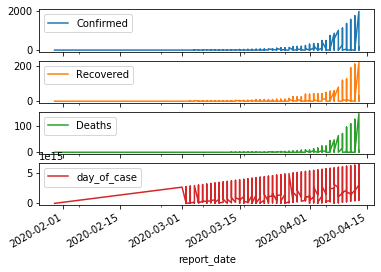

In [358]:
# Test Datewise data 
import matplotlib.pyplot as plt
da_data[['Confirmed', 'Recovered', 'Deaths', 'day_of_case']].plot(subplots=True)
plt.show()

In [63]:
# Calculation of Confirmed case daily values and rate change 

da_data['c_shifted'] = da_data.groupby('State/UT').Confirmed.shift().fillna(0)
da_data['f_shifted'] = da_data.groupby('State/UT').Deaths.shift().fillna(0)
da_data['rate_change_case'] = da_data.Confirmed.div(da_data.c_shifted)
da_data['rate_change_feta'] = da_data.Deaths.div(da_data.f_shifted)
da_data['daily_case'] = abs(da_data.Confirmed.sub(da_data.c_shifted))
da_data.iloc[:,-5:].replace(np.inf, np.nan, inplace=True)
da_data.iloc[:,-5:].fillna(0, inplace=True)

In [65]:
#da_data.iloc[:,-5:].replace([np.inf, -np.inf], np.nan, inplace=True)
#da_data.iloc[:,-5:].fillna(0, inplace=True)

In [66]:
da_data.columns

Index(['State/UT', 'Confirmed', 'Recovered', 'Deaths', 'lockdown_type',
       'DTV18', 'FTV18', 'pop_mi', 'ru_pop', 'urb_pop', 'gender_ratio', 'area',
       'density', 'NumPrimaryHealthCenters_HMIS',
       'TotalPublicHealthFacilities_HMIS', 'NumPublicBeds_HMIS',
       'first_case_date', 'day_of_case', 'c_shifted', 'f_shifted',
       'rate_change_case', 'rate_change_feta', 'daily_case'],
      dtype='object')

In [73]:
da_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 923 entries, 2020-01-30 to 2020-04-13
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   State/UT                          923 non-null    object        
 1   Confirmed                         923 non-null    int64         
 2   Recovered                         923 non-null    int64         
 3   Deaths                            923 non-null    int64         
 4   lockdown_type                     923 non-null    object        
 5   DTV18                             923 non-null    float64       
 6   FTV18                             923 non-null    float64       
 7   pop_mi                            923 non-null    float64       
 8   ru_pop                            923 non-null    float64       
 9   urb_pop                           923 non-null    float64       
 10  gender_ratio                   

In [516]:
da_data.describe()

,Confirmed,Recovered,Deaths,DTV18,FTV18,pop_mi,ru_pop,urb_pop,gender_ratio,area,density,day_of_case,c_shifted,f_shifted,rate_change_case,rate_change_feta,daily_case
count,922.000000,922.000000,922.000000,9.220000e+02,9.220000e+02,9.220000e+02,9.220000e+02,9.220000e+02,922.000000,922.000000,922.000000,922,922.000000,922.000000,891.000000,922.000000,922.000000
mean,80.522777,6.600868,2.258134,7.160322e+07,1.166319e+06,4.384552e+07,2.943221e+07,1.441331e+07,948.298265,113156.914317,925.621367,17 days 03:29:17.049891,70.596529,1.924078,1.210146,0.402923,9.967462
std,189.854668,18.625958,9.510984,9.803922e+07,1.616138e+06,4.576786e+07,3.474287e+07,1.359953e+07,63.551333,97478.858601,2317.794272,13 days 05:00:45.458062,167.929312,8.029174,0.704726,0.579285,28.542005
min,1.000000,0.000000,0.000000,7.655100e+04,9.670000e+02,2.740000e+05,2.899100e+04,1.434880e+05,818.000000,1142.000000,2.800000,0 days 00:00:00,0.000000,0.000000,0.200000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,1.520854e+07,1.395200e+05,1.008629e+07,3.578360e+06,3.049338e+06,895.000000,38863.000000,200.300000,7 days 00:00:00,3.000000,0.000000,1.000000,0.000000,0.000000
50%,13.000000,0.000000,0.000000,2.911442e+07,3.754760e+05,3.340606e+07,1.747114e+07,1.360866e+07,953.000000,94163.000000,318.600000,15 days 00:00:00,11.000000,0.000000,1.000000,0.000000,1.000000
75%,54.000000,5.000000,1.000000,8.565736e+07,1.200969e+06,6.668515e+07,3.722959e+07,1.704808e+07,988.000000,162968.000000,829.300000,24 days 00:00:00,45.000000,1.000000,1.184307,1.000000,6.000000
max,1985.000000,217.000000,149.000000,3.859094e+08,6.074345e+06,1.998123e+08,1.553173e+08,5.081826e+07,1084.000000,342239.000000,11312.600000,74 days 00:00:00,1761.000000,127.000000,15.000000,3.000000,258.000000


In [68]:
da_data.rate_change_case.replace(np.inf, np.nan, inplace=True)

In [72]:
da_data.rate_change_case.fillna(0, inplace=True)

In [70]:
da_data['day_of_case'] = da_data.day_of_case.dt.days

In [81]:
da_data['daily_case'].describe()

count    923.000000
mean      10.173348
std       28.792742
min        0.000000
25%        0.000000
50%        1.000000
75%        6.000000
max      258.000000
Name: daily_case, dtype: float64

### Visualization

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [75]:
df_all = da_data.groupby('report_date')['Confirmed', 'Recovered', 'Deaths','daily_case'].sum().reset_index()

/Volumes/Lab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



### Daily Trends

In [109]:
# Confirmed Cases
# fig = px.line(df_all, x='report_date',  y='Confirmed')
# fig.show()

fig = go.Figure(data=[
    go.Scatter(
        x=df_all['report_date'],
        y=df_all['Confirmed'], name='Confirmed'
    ),
    go.Bar(
        x=df_all['report_date'],
        y=df_all['daily_case'], name='daily_case'
    ),
    go.Scatter(
        x=df_all['report_date'],
        y=df_all['Recovered'], name='Recovered'
    ),
    go.Scatter(
        x=df_all['report_date'],
        y=df_all['Deaths'], name='Deaths'
    )
])

fig.update_layout(title='Covid-19 outbreak in India',
                   xaxis_title='Date',
                   yaxis_title='# Cases')
fig.write_html("/Volumes/Lab/covid19-AnalyticsHbub/India/visuals/covid19in-trend.html")

fig.show()

In [108]:
# Daily Cases
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_all['report_date'],  y=df_all['daily_case'],
              line=dict(color='red', width=4)))

# Edit the layout
fig.update_layout(title='Daily new case trend in Inida',
                   xaxis_title='Date',
                   yaxis_title='Confirmed Cases')
fig.show()

Confirmed Number keep increasing after lockdown on 24th March but daily number is not always exponential increment but not stable in downside, Total Recovery is increasing day by day which is good sign for India at the end of all this what matter most the recovered patient from this pandemic. Number of Deaths is increasing but at 10k 2.5% death ratio is not very high comapre to another country at same stage.

But big question is what is positive point in data to be sure that How India is fight with Covid-19 Virus during the lockdown and what will be the future after extension of lockdown when will all this end.

So what is growth rate of covid-19 in india, is it really exponensial and if it is what is the rate. Fortunetly Statistics could help to understand the pattern in trend and visually interpret what is rate

- To check the rate change please follow the statistical experiemnt: We will going to calculate Expon rate, Linear rate and comapre with actual number

### Understand the Distribution Type of Data 

In [319]:
df_all

,report_date,Confirmed,Recovered,Deaths,daily_case
0,2020-01-30,1,0,0,1.0
1,2020-01-31,1,0,0,0.0
2,2020-02-01,2,0,0,1.0
3,2020-02-02,3,0,0,1.0
4,2020-02-03,3,0,0,0.0
...,...,...,...,...,...
70,2020-04-09,5865,478,169,591.0
71,2020-04-10,6761,516,206,896.0
72,2020-04-11,7529,653,242,768.0
73,2020-04-12,8447,765,273,918.0


In [326]:
df_all.daily_case.mean(), da_data.rate_change_case.mean()

(125.2, 1.1687740931886792)

In [313]:
y_m = df_all.daily_case.mean()
def linear_(x, y_m):
    return 10 + y_m*x
conf_exp = expo(x = np.arange(len(df_all)))

In [352]:
'''
Linear
'''
def linear_(x):
    return 10 + 1000*x

'''
Exponenstial
'''
def expo(x):
    return 10 + 1.18**x

'''
Exponenstial
'''
def logist(x):
    return 30000/(1+ np.exp(-0.5*(x-20)))

conf_exp = expo(x = np.arange(len(df_all)))
conf_lin = linear_(x = np.arange(len(df_all)))
conf_log = logist(x = np.arange(len(df_all)))

In [565]:
# fig, ax = plt.subplots(figsize=(12,6))
# ax.scatter(df['report_date'], df['Confirmed'].values, label = 'Total Confirmed Trend', color='blue')
# ax.scatter(df['report_date'], conf_exp, label = 'exponential', color='red')
# ax.scatter(df['report_date'], conf_lin, label = 'linear', color='green')
# ax.scatter(df['report_date'], conf_log, label = 'logistic', color='black')


# ax.legend()
# plt.show()

In [531]:
fig = go.Figure()
fig.add

In [353]:
from plotly.subplots import make_subplots
fig = go.Figure(data=[
    go.Scatter(
        x=df_all['report_date'],
        y=df_all['Confirmed'], name='Confirmed Actual',mode="markers"
    ),
    go.Scatter(
        x=df_all['report_date'],
        y=conf_exp, name='exponential', line=dict(width=2.5)
    ),
    go.Scatter(
        x=df_all['report_date'],
        y=conf_lin, name='Linear', line=dict(width=3)
    ),
      go.Scatter(
        x=df_all['report_date'],
        y=conf_log, name='Logistic', line=dict(width=2)
    )
])

fig.update_layout(title='Distribution Fit Test with Actual Confirmed cases',
                   xaxis_title='Date',
                   yaxis_title='#Cases')

fig.write_html("/Volumes/Lab/covid19-AnalyticsHbub/India/visuals/covid19in-ftt.html")
fig.show()

Here after applying daily avg rate change for exp and avg daily cases(delta-slop) for linear clearly see that linear line fits most till now then expon curve. So good part that india case is not growing with exp rate. But can we really test 

- To check let's apply Sample Dist. Test like Chi Sq and find its fit to which model most

In [ ]:
da_data.groupby('State/UT')

In [447]:
da_data.columns

Index(['State/UT', 'Confirmed', 'Recovered', 'Deaths', 'lockdown_type',
       'DTV18', 'FTV18', 'pop_mi', 'ru_pop', 'urb_pop', 'gender_ratio', 'area',
       'density', 'NumPrimaryHealthCenters_HMIS',
       'TotalPublicHealthFacilities_HMIS', 'NumPublicBeds_HMIS',
       'first_case_date', 'day_of_case', 'c_shifted', 'f_shifted',
       'rate_change_case', 'rate_change_feta', 'daily_case'],
      dtype='object')

In [620]:
fig = px.scatter(da_data, x="day_of_case", y="daily_case", color="State/UT", trendline="lowess", size='Deaths')
fig.show()

In [559]:
df['month'] = pd.to_datetime(df.report_date).dt.month

In [560]:
df.groupby('month').sum()

,Confirmed,Recovered,Deaths,daily_case
month,,,,
1,2,0,0,1.0
2,86,0,0,2.0
3,9424,797,198,1394.0
4,64730,5289,1884,7793.0


In [580]:
y_std = df['Confirmed']
dist_names = ['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang']
size = len(df)

In [607]:
import scipy
chi_square_statistics = []
# 11 equi-distant bins of observed Data 
percentile_bins = np.linspace(0,100,11)
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

# Loop through candidate distributions
for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    print("{}\n{}\n".format(dist, param))


    # Get expected counts in percentile bins
    # cdf of fitted sistrinution across bins
    cdf_fitted = dist.cdf(percentile_cutoffs, *param)
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)

    # Chi-square Statistics
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square_statistics.append(ss)


#Sort by minimum ch-square statistics
results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square_statistics
results.sort_values(['chi_square'], inplace=True)


print ('\nDistributions listed by Betterment of fit:')
print ('............................................')
print (results)

(0.3565796622765067, 0.9999999999999999, 364.8511596618289)

(989.8933333333333, 2091.7834213788856)

(0.10248760068389981, 9152.000000000002, 1.747964186049574)



/Volumes/Lab/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



(0.2760692386129122, 124.71910322108242, 0.9999999999999999, 120580.54795878209)

(202.12798167562363, 0.3564876838088772, 4.895595943630582)

(1.0, 9151.0)

(0.23400022357112138, 0.9999999999999999, 4257.491443086288)

(1.0, 988.8933333333333)

(3.997288179649663, 0.9999967686075062, 28.108447195622425)

(2.96689285472791, 623.564225629924, 923.5406763153179)

(3.0813140929333063e-15, -217.7739830802817, 9506.012683628935)


Distributions listed by Betterment of fit:
............................................
   Distribution  chi_square
9      pearson3   27.042401
0   weibull_min   88.684510
7         expon   96.047196
4      invgauss  143.669396
6         gamma  160.309339
10       triang  172.239394
1          norm  184.302235
3          beta  198.545653
5       uniform  201.285863
2   weibull_max  272.146313
8       lognorm  344.895942


In [612]:
y_std = df['Confirmed'].values

In [613]:
from scipy.stats import pearson3
param = pearson3.fit(y_std)

In [614]:
param

(2.96689285472791, 623.564225629924, 923.5406763153179)

In [615]:
pdf_fitted = pearson3.pdf(percentile_bins,*param[:-2], loc=param[-2], scale=param[-1])

In [616]:
pdf_fitted

array([0.        , 0.00577229, 0.00381181, 0.00300447, 0.00253747,
       0.00222406, 0.00199513, 0.00181846, 0.00167674, 0.00155975,
       0.00146101])

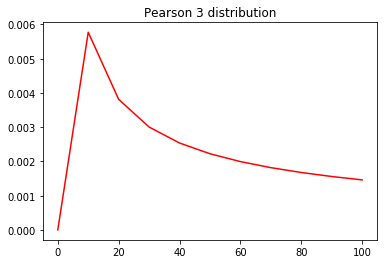

In [617]:
plt.title('Pearson 3 distribution')
plt.plot(percentile_bins,pdf_fitted,'r-')#,x,pdf,'b--')
#dump=plt.hist(y_std,normed=1,alpha=.3)

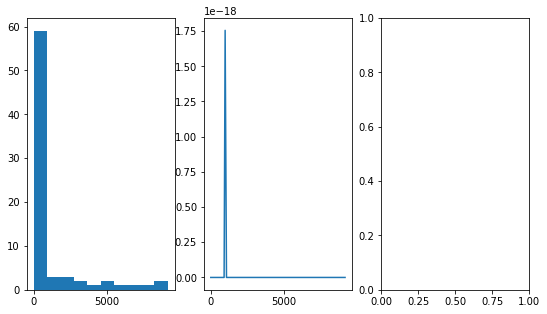

In [619]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
# Histogram Plot of Observed Data
axes[0].hist(y_std)
#Exponential Distribution Fitting
axes[1].plot(y_std,scipy.stats.pearson3.pdf(y_std,2.96689285472791, 923.5406763153179))

In [624]:
da_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 922 entries, 2020-01-30 to 2020-04-13
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   State/UT                          922 non-null    object        
 1   Confirmed                         922 non-null    int64         
 2   Recovered                         922 non-null    int64         
 3   Deaths                            922 non-null    int64         
 4   lockdown_type                     922 non-null    object        
 5   DTV18                             922 non-null    float64       
 6   FTV18                             922 non-null    float64       
 7   pop_mi                            922 non-null    float64       
 8   ru_pop                            922 non-null    float64       
 9   urb_pop                           922 non-null    float64       
 10  gender_ratio                   

In [632]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    1704 non-null   object 
 1   continent  1704 non-null   object 
 2   year       1704 non-null   int64  
 3   lifeExp    1704 non-null   float64
 4   pop        1704 non-null   int64  
 5   gdpPercap  1704 non-null   float64
 6   iso_alpha  1704 non-null   object 
 7   iso_num    1704 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 106.6+ KB


#### Animation

In [298]:
da_data['date'] = da_data.index
df_st = da_data.groupby(['date','State/UT', 'day_of_case']).sum().reset_index()
df_st = df_st.sort_values(by='date') # sort rows based on timestamp
df_st['date'] = df_st.date.apply(lambda x: x.date()).apply(str) # convert timestamp to a string

In [240]:
# df_st = df_st.sort_values(by=['date', 'Confirmed'])
# df_st['date'] = [dt.strftime("%Y-%m-%d") for dt in df_st.date]

In [299]:
df_anim.tail()

,date,State/UT,Confirmed,day_of_case
908,2020-04-13,Madhya Pradesh,604,23
916,2020-04-13,Rajasthan,812,41
917,2020-04-13,Tamil Nadu,1075,37
898,2020-04-13,Delhi,1154,42
909,2020-04-13,Maharashtra,1985,35


In [354]:
df_anim = df_st[['date', 'State/UT', 'Confirmed','day_of_case']].sort_values(by=['date','Confirmed'])
## Animation
fig = px.bar(df_anim[df_anim.date > '2020-03-01'], x="State/UT", y="Confirmed", color='day_of_case',
            animation_frame='date', range_y=[0,2000])

fig.write_html("/Volumes/Lab/covid19-AnalyticsHbub/India/visuals/covid19in-confanim1.html")
fig.show()

In [355]:
df_anim2 = df_st[['date', 'State/UT', 'Recovered','day_of_case']].sort_values(by=['date','Recovered'])
## Animation
fig = px.bar(df_anim2[df_anim2.date > '2020-03-07'], x="State/UT", y="Recovered", color='day_of_case',
            animation_frame='date', range_y=[0,500])

fig.write_html("/Volumes/Lab/covid19-AnalyticsHbub/India/visuals/covid19in-recovanim2.html")
fig.show()

8 new states addes after Lockdown announcement, Kerala is defnetly showing good sign after having first case they took long time to reach in top 6 with high recovery rate.

So there is large diversity in outbreak by states.

- How statistically verify this diversity in uncertain outbreak pattern 

## Clustering

In [324]:
da_data.shape

(923, 24)

In [325]:
da_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 923 entries, 2020-01-30 to 2020-04-13
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   State/UT                          923 non-null    object        
 1   Confirmed                         923 non-null    int64         
 2   Recovered                         923 non-null    int64         
 3   Deaths                            923 non-null    int64         
 4   lockdown_type                     923 non-null    object        
 5   DTV18                             923 non-null    float64       
 6   FTV18                             923 non-null    float64       
 7   pop_mi                            923 non-null    float64       
 8   ru_pop                            923 non-null    float64       
 9   urb_pop                           923 non-null    float64       
 10  gender_ratio                   

In [338]:
da_data.iloc[:, 13:16].values

array([['933', '1297', '39511'],
       ['933', '1297', '39511'],
       ['933', '1297', '39511'],
       ...,
       ['1417', '1666', '60799'],
       ['933', '1297', '39511'],
       ['1374', '1905', '51163']], dtype=object)

In [343]:
# Categorical to Numeric
da_data[da_data.iloc[:, 13:16].columns] = da_data.iloc[:, 13:16].apply(pd.to_numeric, errors='coerce')

In [346]:
da_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 923 entries, 2020-01-30 to 2020-04-13
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   State/UT                          923 non-null    object        
 1   Confirmed                         923 non-null    int64         
 2   Recovered                         923 non-null    int64         
 3   Deaths                            923 non-null    int64         
 4   lockdown_type                     923 non-null    object        
 5   DTV18                             923 non-null    float64       
 6   FTV18                             923 non-null    float64       
 7   pop_mi                            923 non-null    float64       
 8   ru_pop                            923 non-null    float64       
 9   urb_pop                           923 non-null    float64       
 10  gender_ratio                   

In [347]:
da_data.columns

Index(['State/UT', 'Confirmed', 'Recovered', 'Deaths', 'lockdown_type',
       'DTV18', 'FTV18', 'pop_mi', 'ru_pop', 'urb_pop', 'gender_ratio', 'area',
       'density', 'NumPrimaryHealthCenters_HMIS',
       'TotalPublicHealthFacilities_HMIS', 'NumPublicBeds_HMIS',
       'first_case_date', 'day_of_case', 'c_shifted', 'f_shifted',
       'rate_change_case', 'rate_change_feta', 'daily_case', 'date'],
      dtype='object')

In [348]:
da_clust = da_data[['State/UT', 'Confirmed', 'Deaths', 'lockdown_type',
       'DTV18', 'FTV18', 'pop_mi', 'ru_pop', 'urb_pop', 'gender_ratio', 'area',
       'density', 'NumPrimaryHealthCenters_HMIS',
       'TotalPublicHealthFacilities_HMIS', 'NumPublicBeds_HMIS',
       'day_of_case',  'rate_change_case', 'rate_change_feta', 'daily_case']]

In [349]:
da_clust.head()

,State/UT,Confirmed,Deaths,lockdown_type,DTV18,FTV18,pop_mi,ru_pop,urb_pop,gender_ratio,area,density,NumPrimaryHealthCenters_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,day_of_case,rate_change_case,rate_change_feta,daily_case
report_date,,,,,,,,,,,,,,,,,,,
2020-01-30,Kerala,1,0,Open,15604661.0,1096407.0,33406061.0,17471135.0,15934926.0,1084.0,38863.0,859.6,933,1297,39511,0,0.0,0.0,1.0
2020-01-31,Kerala,1,0,Open,15604661.0,1096407.0,33406061.0,17471135.0,15934926.0,1084.0,38863.0,859.6,933,1297,39511,1,1.0,0.0,0.0
2020-02-01,Kerala,2,0,Open,15604661.0,1096407.0,33406061.0,17471135.0,15934926.0,1084.0,38863.0,859.6,933,1297,39511,2,2.0,0.0,1.0
2020-02-02,Kerala,3,0,Open,15604661.0,1096407.0,33406061.0,17471135.0,15934926.0,1084.0,38863.0,859.6,933,1297,39511,3,1.5,0.0,1.0
2020-02-03,Kerala,3,0,Open,15604661.0,1096407.0,33406061.0,17471135.0,15934926.0,1084.0,38863.0,859.6,933,1297,39511,4,1.0,0.0,0.0


In [358]:
# One-hot Encoding 
da_clust = pd.concat([da_clust, pd.get_dummies(da_clust['lockdown_type'], prefix='LockdowType')], axis=1)

In [362]:
num = [f for f in da_clust.columns if da_clust.dtypes[f] != 'object']

In [365]:
corr = da_clust[num].corr()

In [384]:
matrix = corr.abs().unstack().reset_index()
matrix.columns = ['label1', 'label2', 'value']

In [385]:
matrix[matrix.label1 == 'Confirmed'].sort_values(by='value', ascending=False)

,label1,label2,value
0,Confirmed,Confirmed,1.000000
16,Confirmed,daily_case,0.809991
1,Confirmed,Deaths,0.791349
13,Confirmed,day_of_case,0.494829
15,Confirmed,rate_change_feta,0.474427
6,Confirmed,urb_pop,0.373211
3,Confirmed,FTV18,0.368779
12,Confirmed,NumPublicBeds_HMIS,0.330335
18,Confirmed,LockdowType_National,0.274083
11,Confirmed,TotalPublicHealthFacilities_HMIS,0.267480


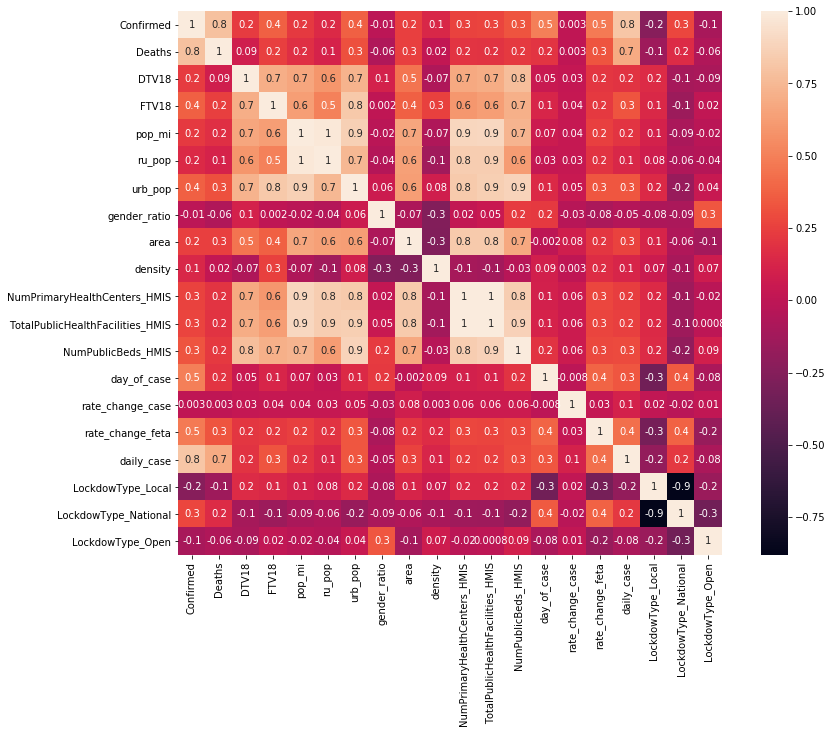

In [371]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [14, 10]
sns.heatmap(corr,square=True, fmt='.1g', annot=True)